## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from openpyxl import Workbook, load_workbook
from openpyxl.styles import Font

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from utils.layer_wrappers import ModuleWrapperLinear, ModuleWrapperConv1d
from layers.BayesianConv1d import BayesianConv1d
from layers.BayesianLinear import BayesianLinear

## Parameters

In [2]:
BATCH_SIZE = 64
NUM_CLASSES = 3
LR = 1e-3
KL_WEIGHT = 1e-8
EPOCHS = 15
T = 15

PRIORS = {
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0.0, 0.1),
    'posterior_rho_initial': (-3.0, 0.1)
}  

SITE = 'B'
YEAR = 2020

flag_subsampled = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


## Loading Files

In [3]:
X = np.load(f'/kaggle/input/data-usa/Site_{SITE}/x-{YEAR}.npy')
y = np.load(f'/kaggle/input/data-usa/Site_{SITE}/y-{YEAR}.npy')

print(f'Loaded Data of Site {SITE} - {YEAR}')
print(X.shape, y.shape)

Loaded Data of Site B - 2020
(1943716, 28, 6) (1943716,)


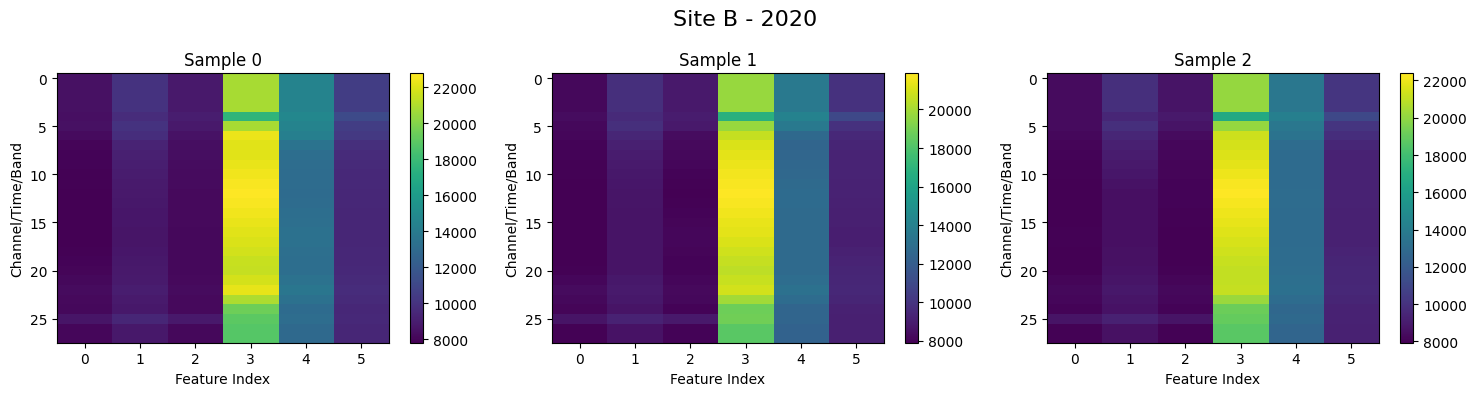

In [4]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site B - 2020 =======
Feature 0: Mean = 9293.7332, Std = 1062.0828
Feature 1: Mean = 10402.3986, Std = 1328.2403
Feature 2: Mean = 10579.1004, Std = 1999.1082
Feature 3: Mean = 18968.7555, Std = 4274.7314
Feature 4: Mean = 16319.4431, Std = 3346.2848
Feature 5: Mean = 13205.7260, Std = 3494.6972

Global Mean: 13128.1928
Global Std Dev: 4500.1056


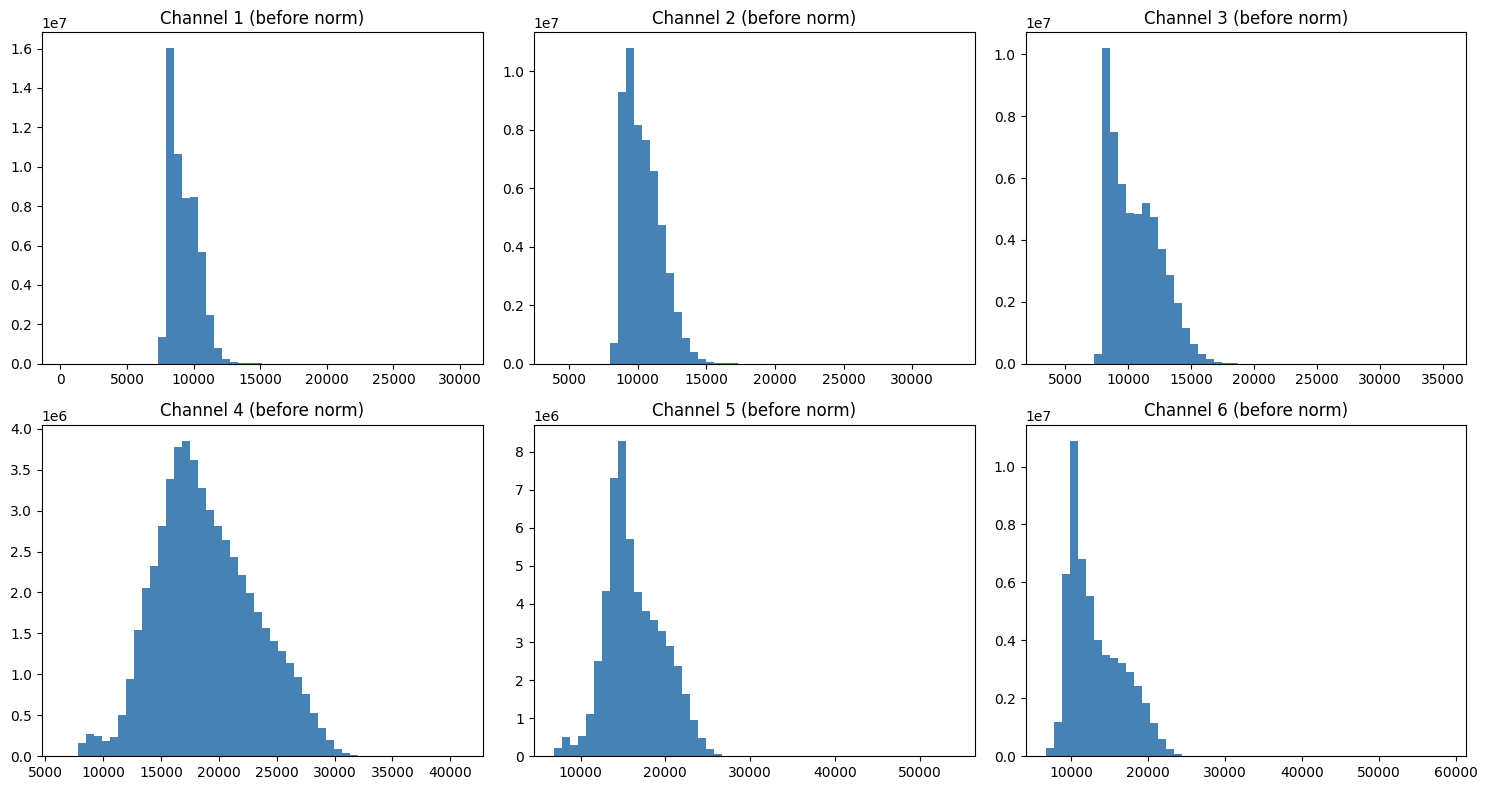

In [6]:
X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

# Before normalization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i in range(6):
    axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
    axs[i].set_title(f'Channel {i+1} (before norm)')
plt.tight_layout()
plt.show()

## Preprocessing the Input

In [7]:
# Standardizing the input features across all timesteps and samples using Z-scores
# Compute per-feature mean and std across all samples and timesteps
feature_means = X.mean(axis=(0, 1))  # Shape: (6,)
feature_stds = X.std(axis=(0, 1))    # Shape: (6,)

# Reshape for broadcasting
feature_means = feature_means.reshape(1, 1, -1)  # Shape: (1, 1, 6)
feature_stds = feature_stds.reshape(1, 1, -1)    # Shape: (1, 1, 6)

# Standardize
X = ((X - feature_means) / feature_stds).astype(np.float32)

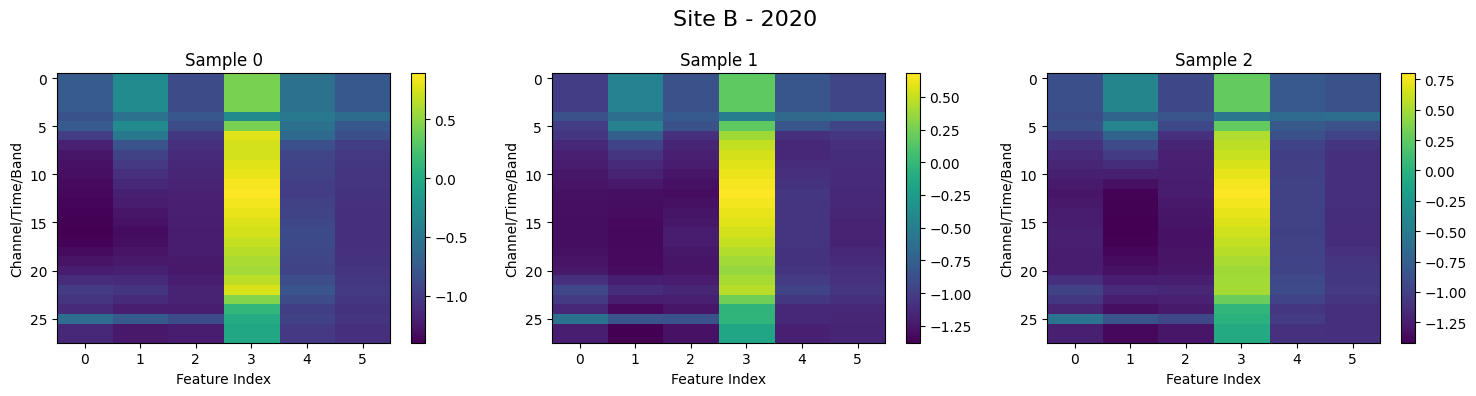

In [8]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site B - 2020 =======
Feature 0: Mean = -0.0000, Std = 0.8846
Feature 1: Mean = -0.0000, Std = 0.8950
Feature 2: Mean = 0.0000, Std = 0.8862
Feature 3: Mean = 0.0001, Std = 0.9253
Feature 4: Mean = 0.0000, Std = 0.9230
Feature 5: Mean = 0.0000, Std = 0.8994

Global Mean: -0.0000
Global Std Dev: 1.0000


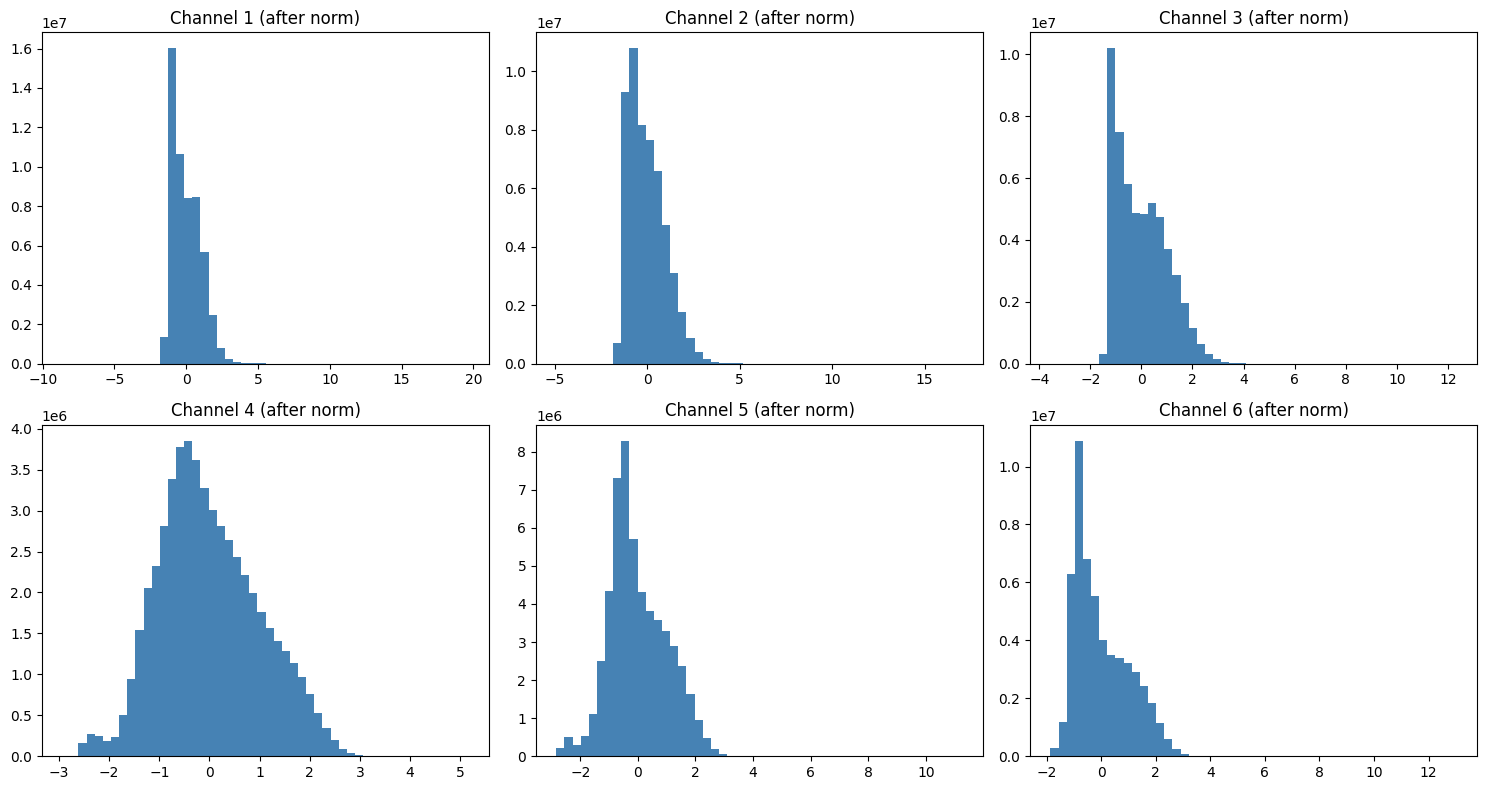

In [10]:
X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

# After normalization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i in range(6):
    axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
    axs[i].set_title(f'Channel {i+1} (after norm)')
plt.tight_layout()
plt.show()

## Label Distribution



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


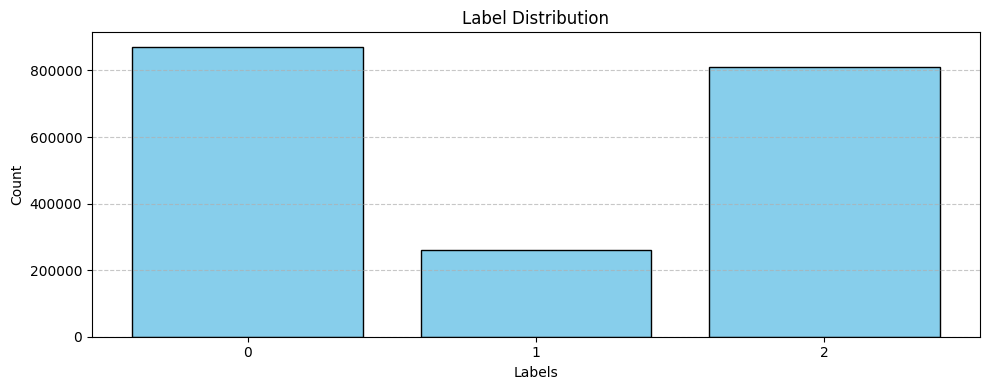

In [11]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution ======')
unique_labels, counts = np.unique(y, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Data Splits

In [12]:
# Taking only 25% percent of the data
X_subset, X_test, y_subset, y_test = train_test_split(X, y, test_size=0.75, stratify=y, random_state=42)
print('Subset Data:', X_subset.shape, y_subset.shape)
print('Test Data:', X_test.shape, y_test.shape)

Subset Data: (485929, 28, 6) (485929,)
Test Data: (1457787, 28, 6) (1457787,)


In [13]:
# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(X_subset, y_subset, test_size=0.2, stratify=y_subset, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(388743, 28, 6) (388743,)
(97186, 28, 6) (97186,)


In [14]:
# Checking if the training data is normalized correctly
print(f'\n\n======= Training data =======')
feature_means = X_train.mean(axis=(0, 1))  # average over samples and features
feature_stds = X_train.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X_train.mean()
std = X_train.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= Training data =======
Feature 0: Mean = 0.0013, Std = 0.9957
Feature 1: Mean = 0.0013, Std = 0.9936
Feature 2: Mean = 0.0009, Std = 0.9921
Feature 3: Mean = 0.0006, Std = 0.9914
Feature 4: Mean = 0.0005, Std = 0.9904
Feature 5: Mean = 0.0004, Std = 0.9946

Global Mean: 0.0008
Global Std Dev: 1.0006




====== Label Distribution - Training data ======
Label     Count     Percentage
------------------------------
0         174206    44.81%
1         52155     13.42%
2         162382    41.77%

Total samples: 388743


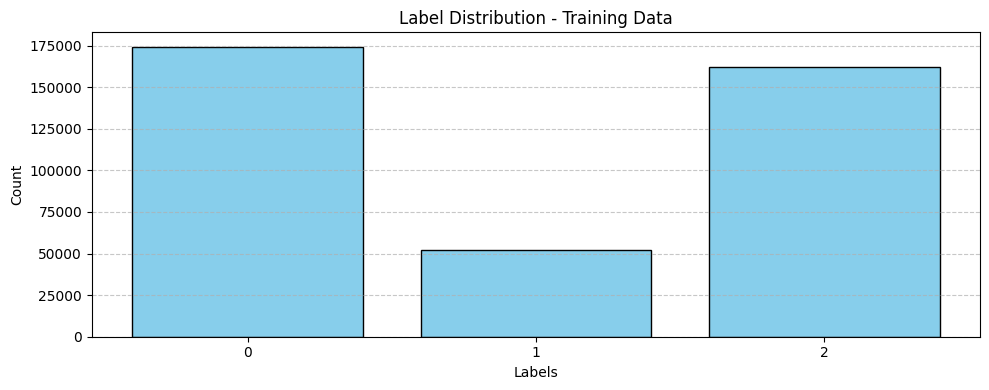

In [15]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution - Training data ======')
unique_labels, counts = np.unique(y_train, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution - Training Data")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Dataset and DataLoader

In [16]:
class Conv1dDataset(Dataset):
    def __init__(self, X, y):
        """
        X expected shape: (N, T, F)  -> convert to (N, C, L) with C=F, L=T
        Transpose to (N, F, T)
        """
        self.X = torch.tensor(X.transpose(0, 2, 1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
train_dataset = Conv1dDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = Conv1dDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = Conv1dDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [18]:
# Blocks (Conv + FC) 
# ----------------------------
class Conv1d_BayesBlock(ModuleWrapperConv1d):
    """BBBConv1d + BN + ReLU inside a Conv1d wrapper"""
    def __init__(self, in_ch, out_ch, kernel_size, priors, device='cpu', padding=0):
        super().__init__()
        self.conv = BayesianConv1d(in_ch, out_ch, kernel_size, padding=padding, priors=priors, device=device)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.ReLU()

class FCBayesBlock(ModuleWrapperLinear):
    """BBBLinear (optionally add activation if you want)"""
    def __init__(self, in_f, out_f, priors, device='cpu'):
        super().__init__()
        self.fc = BayesianLinear(in_f, out_f, priors=priors, device=device)

In [19]:
########################################
# Bayesian CNN + FC Model
########################################
class BayesianCNN_FC(nn.Module):
    def __init__(self, in_channels=6,  num_classes=3, priors=None, device='cpu'):
        super().__init__()
        self.device = device
        self.conv1 = Conv1d_BayesBlock(in_channels, 64, 5, priors, device=device, padding=2)
        self.conv2 = Conv1d_BayesBlock(64, 128, 5, priors, device=device, padding=2)
        self.conv3 = Conv1d_BayesBlock(128, 256, 5, priors, device=device, padding=2)
        self.conv4 = Conv1d_BayesBlock(256, 512, 5, priors, device=device, padding=2)
        self.conv5 = Conv1d_BayesBlock(512, 1024, 5, priors, device=device, padding=2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = FCBayesBlock(1024, num_classes, priors, device=device)

    def forward(self, x, sample=True, n_samples=1):
        # x: (batch, channels, length)  OR  (n_samples, batch, channels, length)
        kl_total = torch.tensor(0.0, device=x.device)

        x, kl = self.conv1(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv2(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv3(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv4(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv5(x, sample=sample, n_samples=n_samples); kl_total += kl

        # global pool (handle sample dim)
        if x.dim() == 4:  # (T, B, C, L)
            T_, B_, C_, L_ = x.shape
            x = x.reshape(T_ * B_, C_, L_)
            x = self.global_pool(x)             # (T*B, C, 1)
            x = x.squeeze(-1)                   # (T*B, C)
            x = x.reshape(T_, B_, C_)           # (T, B, C)
        elif x.dim() == 3:  # (B, C, L)
            x = self.global_pool(x)             # (B, C, 1)
            x = x.squeeze(-1)                   # (B, C)
        else:
            raise ValueError(f"Unexpected shape: {x.shape}")

        x, kl_fc = self.fc(x, sample=sample, n_samples=n_samples)
        kl_total += kl_fc

        return x, kl_total

In [20]:
########################################
# Model Initialization
########################################
if not flag_subsampled:
    model = BayesianCNN_FC(in_channels=6, num_classes=3, priors=PRIORS, device=DEVICE).to(DEVICE)
    model = torch.compile(model, backend='eager')
    print(model)
    
    # Loading model trained on SiteA-2019
    checkpoint = torch.load("/kaggle/input/bcnn/pytorch/default/1/BCNN.pth", map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint)

## Evaluation Function

In [21]:
def compute_accuracy_per_sample_mean(outputs, labels):
    """
    outputs: (T, B, C) or (B, C)
    """
    if outputs.dim() == 3:
        preds = outputs.argmax(dim=2)               # (T, B)
        eq = (preds == labels.unsqueeze(0))         # (T, B)
        return eq.float().mean(dim=1).mean().item() # avg over T, then scalar
    else:
        preds = outputs.argmax(dim=1)
        return (preds == labels).float().mean().item()

In [22]:
def evaluate(model, dataloader, T, device):
    sample_flag = (T > 1)
    
    all_preds = []
    all_labels = []
    total_acc = 0.0

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm(dataloader, desc=f"Stochastic Validation (T={T})" if sample_flag else f"Deterministic Validation (T={T})"):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            
            outputs, _ = model(x_batch, sample=sample_flag, n_samples=T)  # (T,B,C) or (B,C)

            # Accuracy before averaging predictions
            total_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)

            # Average over stochastic passes if T>1
            if sample_flag and outputs.dim() == 3:
                outputs = outputs.mean(dim=0)  # (B, C)

            # Get predictions
            probs = torch.softmax(outputs, dim=1)  # (B, C)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # ====== Metrics ======
    kappa = cohen_kappa_score(all_labels.numpy(), all_preds.numpy())
    per_class_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)
    avg_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")
    acc = total_acc / len(dataloader.dataset)
    cm = confusion_matrix(all_labels, all_preds)

    return acc, kappa, per_class_f1, avg_f1, cm

In [23]:
# acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, T, device=DEVICE)

# # Printing and plotting
# print("Stochastic" + f" Accuracy (mean over T): {acc:.4f}" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
# print(f"Cohen's Kappa: {kappa:.4f}")
# print(f"Per-class F1: {per_class_f1}")
# print(f"Average F1 (macro): {avg_f1:.4f}")

# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap="Blues")
# plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
# plt.tight_layout()
# plt.show()

## Training Loop

In [24]:
# ===== Class weights =====
all_labels = []
for _, y_batch in train_dataloader:
    all_labels.append(y_batch.numpy())

all_labels = np.concatenate(all_labels)
classes = np.unique(all_labels)
class_weights_np = compute_class_weight(class_weight='balanced',
                                        classes=classes, y=all_labels)
class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(DEVICE)
class_weights = torch.clamp(class_weights, max=1.25) # Clipping to max 1.00
print("Class weights:", class_weights)

Class weights: tensor([0.7438, 1.2500, 0.7980], device='cuda:0')


In [25]:
# ===== Optimizer =====
if not flag_subsampled:
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [26]:
def ELBO_loss_nll_from_logits(outputs, y_batch, class_weights=None):
    """
    outputs: (T, B, C) or (B, C)
    y_batch: (B,)
    """
    if outputs.dim() == 3:
        T, B, C = outputs.shape
        outputs_flat = outputs.reshape(T * B, C)
        labels_rep = y_batch.unsqueeze(0).expand(T, B).reshape(T * B)
        return F.cross_entropy(outputs_flat, labels_rep,
                               weight=class_weights, reduction='mean')
    else:
        return F.cross_entropy(outputs, y_batch,
                               weight=class_weights, reduction='mean')

In [27]:
# ===== Training Loop =====
def train(model, train_dataset, train_loader, val_loader, optimizer, KL_WEIGHT=1e-8, EPOCHS=15, T=15):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(EPOCHS):
        # === TRAIN ===
        model.train()
        train_loss = 0.0
        train_acc = 0.0
    
        for x_batch, y_batch in tqdm(train_loader, desc=f'Training Epoch {epoch+1}'):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
    
            optimizer.zero_grad()
    
            # Forward pass with T stochastic samples
            outputs, kl = model(x_batch, sample=True, n_samples=T)  # (T,B,C) + scalar KL
    
            # Mean NLL across T samples
            nll_mean = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
            
            # ELBO Loss
            loss = nll_mean + KL_WEIGHT * kl
    
            # Backprop
            loss.backward()
            optimizer.step()
    
            # Stats
            train_loss += loss.item() * x_batch.size(0)
            train_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)
    
        train_loss /= len(train_dataset)
        train_acc /= len(train_dataset)
        print(f'Loss: {nll_mean:.4f} + {KL_WEIGHT} * {kl}')
    
        # === VALIDATION ===
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
    
        with torch.no_grad():
            for x_batch, y_batch in tqdm(val_loader, desc='Validation'):
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
    
                outputs, kl = model(x_batch, sample=False, n_samples=1)  # deterministic eval
                nll = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
                loss = nll + KL_WEIGHT * kl
    
                val_loss += loss.item() * x_batch.size(0)
                val_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)
    
        val_loss /= len(val_dataset)
        val_acc /= len(val_dataset)
    
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
    
        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}") 

    return train_losses, val_losses, train_accs, val_accs

In [28]:
# Subsampled Training
def subsampled_training(X_train, y_train, val_dataloader, start, end, step):
    subset_sizes = list(range(start, end+1, step))
    print(subset_sizes)
    
    elbow_history = {
        "subset_size": [],
        "train_accuracy": [],
        "train_loss": [],
        "val_accuracy": [],
        "val_loss": [],
        "val_avg_f1": [],
        "kappa": []
    }
    
    for size in subset_sizes:
        print(f"\nTraining with {size} samples...")
        
        subset_indices = np.arange(size)
        X_subsample = X_train[subset_indices]
        y_subsample = y_train[subset_indices]
    
        # Create dataset & dataloader
        subsample_dataset = Conv1dDataset(X_subsample, y_subsample)
        subsample_loader = DataLoader(subsample_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
        # Fresh model for each subset and optimizer
        model = BayesianCNN_FC(in_channels=6, num_classes=3, priors=PRIORS, device=DEVICE).to(DEVICE)
        model = torch.compile(model, backend='eager')
        checkpoint = torch.load("/kaggle/input/bcnn/pytorch/default/1/BCNN.pth", map_location=torch.device("cpu"))
        model.load_state_dict(checkpoint)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)  
    
        # Train
        train_losses, val_losses, train_accs, val_accs = train(model, subsample_dataset, subsample_loader, val_dataloader, optimizer, KL_WEIGHT=KL_WEIGHT, EPOCHS=EPOCHS, T=T)
        # Evaluate
        acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, T, device=DEVICE)
    
        # Printing and plotting
        print("Stochastic" + f" Accuracy (mean over T): {acc:.4f}" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
        print(f"Cohen's Kappa: {kappa:.4f}")
        print(f"Per-class F1: {per_class_f1}")
        print(f"Average F1 (macro): {avg_f1:.4f}")
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
        plt.tight_layout()
        plt.show()
        
        # Save final epoch stats
        elbow_history["subset_size"].append(size)
        elbow_history["train_loss"].append(train_losses[-1])
        elbow_history["train_accuracy"].append(train_accs[-1])
        elbow_history["val_accuracy"].append(val_accs[-1])
        elbow_history["val_loss"].append(val_losses[-1])
        elbow_history["val_avg_f1"].append(avg_f1)
        elbow_history["kappa"].append(kappa)

    return elbow_history

## Training

[13000, 13300, 13600, 13900, 14200, 14500, 14800, 15100, 15400, 15700, 16000]

Training with 13000 samples...


Training Epoch 1: 100%|██████████| 204/204 [00:08<00:00, 23.24it/s]


Loss: 0.4326 + 1e-08 * 2862814.0


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 133.42it/s]


Epoch [1/15] Train Loss: 0.4869, Train Acc: 0.8335 | Val Loss: 0.3373, Val Acc: 0.8774


Training Epoch 2: 100%|██████████| 204/204 [00:04<00:00, 44.08it/s]


Loss: 0.3234 + 1e-08 * 2844530.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.95it/s]


Epoch [2/15] Train Loss: 0.3125, Train Acc: 0.8891 | Val Loss: 0.3103, Val Acc: 0.8900


Training Epoch 3: 100%|██████████| 204/204 [00:04<00:00, 44.02it/s]


Loss: 0.5043 + 1e-08 * 2823388.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.52it/s]


Epoch [3/15] Train Loss: 0.2850, Train Acc: 0.9013 | Val Loss: 0.3057, Val Acc: 0.8895


Training Epoch 4: 100%|██████████| 204/204 [00:04<00:00, 43.92it/s]


Loss: 0.3240 + 1e-08 * 2806888.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.74it/s]


Epoch [4/15] Train Loss: 0.2670, Train Acc: 0.9066 | Val Loss: 0.3009, Val Acc: 0.8913


Training Epoch 5: 100%|██████████| 204/204 [00:04<00:00, 43.87it/s]


Loss: 0.3657 + 1e-08 * 2790378.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.21it/s]


Epoch [5/15] Train Loss: 0.2591, Train Acc: 0.9102 | Val Loss: 0.2927, Val Acc: 0.8948


Training Epoch 6: 100%|██████████| 204/204 [00:04<00:00, 44.05it/s]


Loss: 0.2788 + 1e-08 * 2781757.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.69it/s]


Epoch [6/15] Train Loss: 0.2444, Train Acc: 0.9172 | Val Loss: 0.2936, Val Acc: 0.8974


Training Epoch 7: 100%|██████████| 204/204 [00:04<00:00, 43.88it/s]


Loss: 0.2684 + 1e-08 * 2767872.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.03it/s]


Epoch [7/15] Train Loss: 0.2301, Train Acc: 0.9206 | Val Loss: 0.2938, Val Acc: 0.8981


Training Epoch 8: 100%|██████████| 204/204 [00:04<00:00, 43.75it/s]


Loss: 1.5792 + 1e-08 * 2760880.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.64it/s]


Epoch [8/15] Train Loss: 0.2228, Train Acc: 0.9256 | Val Loss: 0.2940, Val Acc: 0.8972


Training Epoch 9: 100%|██████████| 204/204 [00:04<00:00, 44.04it/s]


Loss: 0.0691 + 1e-08 * 2760021.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.77it/s]


Epoch [9/15] Train Loss: 0.2156, Train Acc: 0.9275 | Val Loss: 0.3054, Val Acc: 0.8932


Training Epoch 10: 100%|██████████| 204/204 [00:04<00:00, 43.81it/s]


Loss: 0.4015 + 1e-08 * 2755488.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.35it/s]


Epoch [10/15] Train Loss: 0.2023, Train Acc: 0.9318 | Val Loss: 0.3070, Val Acc: 0.8976


Training Epoch 11: 100%|██████████| 204/204 [00:04<00:00, 43.89it/s]


Loss: 1.0266 + 1e-08 * 2760674.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.57it/s]


Epoch [11/15] Train Loss: 0.1959, Train Acc: 0.9355 | Val Loss: 0.3240, Val Acc: 0.8891


Training Epoch 12: 100%|██████████| 204/204 [00:04<00:00, 43.80it/s]


Loss: 0.1126 + 1e-08 * 2763760.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.08it/s]


Epoch [12/15] Train Loss: 0.1857, Train Acc: 0.9386 | Val Loss: 0.3133, Val Acc: 0.8931


Training Epoch 13: 100%|██████████| 204/204 [00:04<00:00, 44.00it/s]


Loss: 0.4321 + 1e-08 * 2767572.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.86it/s]


Epoch [13/15] Train Loss: 0.1716, Train Acc: 0.9435 | Val Loss: 0.3184, Val Acc: 0.8937


Training Epoch 14: 100%|██████████| 204/204 [00:04<00:00, 43.82it/s]


Loss: 0.5669 + 1e-08 * 2774915.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.17it/s]


Epoch [14/15] Train Loss: 0.1668, Train Acc: 0.9458 | Val Loss: 0.3272, Val Acc: 0.8934


Training Epoch 15: 100%|██████████| 204/204 [00:04<00:00, 44.01it/s]


Loss: 0.2245 + 1e-08 * 2781093.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.40it/s]


Epoch [15/15] Train Loss: 0.1539, Train Acc: 0.9512 | Val Loss: 0.3473, Val Acc: 0.8864


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:40<00:00, 142.00it/s]


Stochastic Accuracy (mean over T): 0.8867
Cohen's Kappa: 0.8132
Per-class F1: [0.88684632 0.90270505 0.88144536]
Average F1 (macro): 0.8903


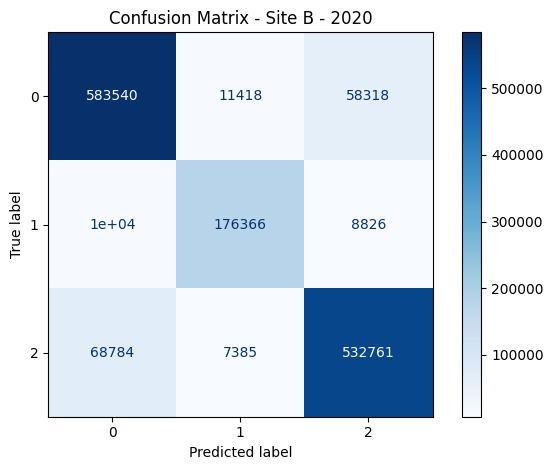


Training with 13300 samples...


Training Epoch 1: 100%|██████████| 208/208 [00:04<00:00, 43.64it/s]


Loss: 0.4195 + 1e-08 * 2860059.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.35it/s]


Epoch [1/15] Train Loss: 0.4790, Train Acc: 0.8354 | Val Loss: 0.3388, Val Acc: 0.8785


Training Epoch 2: 100%|██████████| 208/208 [00:04<00:00, 43.78it/s]


Loss: 0.2445 + 1e-08 * 2838787.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.34it/s]


Epoch [2/15] Train Loss: 0.3122, Train Acc: 0.8902 | Val Loss: 0.3271, Val Acc: 0.8813


Training Epoch 3: 100%|██████████| 208/208 [00:04<00:00, 43.74it/s]


Loss: 0.2658 + 1e-08 * 2819187.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.14it/s]


Epoch [3/15] Train Loss: 0.2860, Train Acc: 0.9020 | Val Loss: 0.3049, Val Acc: 0.8904


Training Epoch 4: 100%|██████████| 208/208 [00:04<00:00, 43.91it/s]


Loss: 0.3549 + 1e-08 * 2800842.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.86it/s]


Epoch [4/15] Train Loss: 0.2718, Train Acc: 0.9062 | Val Loss: 0.3049, Val Acc: 0.8949


Training Epoch 5: 100%|██████████| 208/208 [00:04<00:00, 43.58it/s]


Loss: 0.1077 + 1e-08 * 2783753.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.10it/s]


Epoch [5/15] Train Loss: 0.2546, Train Acc: 0.9119 | Val Loss: 0.2960, Val Acc: 0.8963


Training Epoch 6: 100%|██████████| 208/208 [00:04<00:00, 43.71it/s]


Loss: 0.2654 + 1e-08 * 2767701.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.25it/s]


Epoch [6/15] Train Loss: 0.2411, Train Acc: 0.9184 | Val Loss: 0.2955, Val Acc: 0.8948


Training Epoch 7: 100%|██████████| 208/208 [00:04<00:00, 43.76it/s]


Loss: 0.3734 + 1e-08 * 2756741.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.39it/s]


Epoch [7/15] Train Loss: 0.2311, Train Acc: 0.9229 | Val Loss: 0.3019, Val Acc: 0.8930


Training Epoch 8: 100%|██████████| 208/208 [00:04<00:00, 44.02it/s]


Loss: 0.1140 + 1e-08 * 2749414.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.00it/s]


Epoch [8/15] Train Loss: 0.2191, Train Acc: 0.9249 | Val Loss: 0.2951, Val Acc: 0.8954


Training Epoch 9: 100%|██████████| 208/208 [00:04<00:00, 43.87it/s]


Loss: 0.2170 + 1e-08 * 2748135.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.25it/s]


Epoch [9/15] Train Loss: 0.2119, Train Acc: 0.9298 | Val Loss: 0.2987, Val Acc: 0.8968


Training Epoch 10: 100%|██████████| 208/208 [00:04<00:00, 44.04it/s]


Loss: 0.0824 + 1e-08 * 2747405.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.15it/s]


Epoch [10/15] Train Loss: 0.1979, Train Acc: 0.9354 | Val Loss: 0.3021, Val Acc: 0.8976


Training Epoch 11: 100%|██████████| 208/208 [00:04<00:00, 43.97it/s]


Loss: 0.0753 + 1e-08 * 2748992.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.42it/s]


Epoch [11/15] Train Loss: 0.1885, Train Acc: 0.9382 | Val Loss: 0.3173, Val Acc: 0.8928


Training Epoch 12: 100%|██████████| 208/208 [00:04<00:00, 43.98it/s]


Loss: 0.0721 + 1e-08 * 2754217.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.05it/s]


Epoch [12/15] Train Loss: 0.1767, Train Acc: 0.9430 | Val Loss: 0.3412, Val Acc: 0.8853


Training Epoch 13: 100%|██████████| 208/208 [00:04<00:00, 43.99it/s]


Loss: 0.0686 + 1e-08 * 2758935.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.45it/s]


Epoch [13/15] Train Loss: 0.1668, Train Acc: 0.9457 | Val Loss: 0.3250, Val Acc: 0.8929


Training Epoch 14: 100%|██████████| 208/208 [00:04<00:00, 43.85it/s]


Loss: 0.1012 + 1e-08 * 2768700.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.10it/s]


Epoch [14/15] Train Loss: 0.1576, Train Acc: 0.9519 | Val Loss: 0.3488, Val Acc: 0.8897


Training Epoch 15: 100%|██████████| 208/208 [00:04<00:00, 44.01it/s]


Loss: 0.0929 + 1e-08 * 2780162.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.01it/s]


Epoch [15/15] Train Loss: 0.1475, Train Acc: 0.9538 | Val Loss: 0.3461, Val Acc: 0.8929


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:39<00:00, 143.09it/s]


Stochastic Accuracy (mean over T): 0.8929
Cohen's Kappa: 0.8234
Per-class F1: [0.89284056 0.90373878 0.88956832]
Average F1 (macro): 0.8954


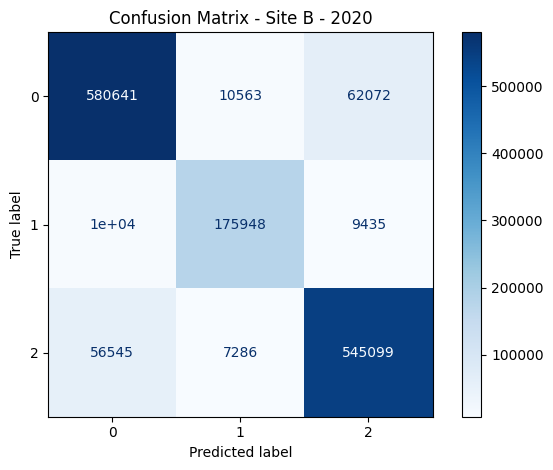


Training with 13600 samples...


Training Epoch 1: 100%|██████████| 213/213 [00:04<00:00, 43.95it/s]


Loss: 0.4353 + 1e-08 * 2863357.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.60it/s]


Epoch [1/15] Train Loss: 0.4806, Train Acc: 0.8342 | Val Loss: 0.3409, Val Acc: 0.8767


Training Epoch 2: 100%|██████████| 213/213 [00:04<00:00, 44.01it/s]


Loss: 0.1817 + 1e-08 * 2842420.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.40it/s]


Epoch [2/15] Train Loss: 0.3095, Train Acc: 0.8888 | Val Loss: 0.3110, Val Acc: 0.8879


Training Epoch 3: 100%|██████████| 213/213 [00:04<00:00, 43.93it/s]


Loss: 0.1933 + 1e-08 * 2821895.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.74it/s]


Epoch [3/15] Train Loss: 0.2861, Train Acc: 0.8990 | Val Loss: 0.3073, Val Acc: 0.8915


Training Epoch 4: 100%|██████████| 213/213 [00:04<00:00, 43.99it/s]


Loss: 0.2263 + 1e-08 * 2802932.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.63it/s]


Epoch [4/15] Train Loss: 0.2708, Train Acc: 0.9055 | Val Loss: 0.2940, Val Acc: 0.8932


Training Epoch 5: 100%|██████████| 213/213 [00:04<00:00, 44.07it/s]


Loss: 0.3612 + 1e-08 * 2784339.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.98it/s]


Epoch [5/15] Train Loss: 0.2555, Train Acc: 0.9124 | Val Loss: 0.3033, Val Acc: 0.8908


Training Epoch 6: 100%|██████████| 213/213 [00:04<00:00, 44.20it/s]


Loss: 0.1590 + 1e-08 * 2770276.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.08it/s]


Epoch [6/15] Train Loss: 0.2451, Train Acc: 0.9168 | Val Loss: 0.2940, Val Acc: 0.8948


Training Epoch 7: 100%|██████████| 213/213 [00:04<00:00, 43.93it/s]


Loss: 0.2863 + 1e-08 * 2757891.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.26it/s]


Epoch [7/15] Train Loss: 0.2311, Train Acc: 0.9202 | Val Loss: 0.2983, Val Acc: 0.8962


Training Epoch 8: 100%|██████████| 213/213 [00:04<00:00, 44.08it/s]


Loss: 0.1538 + 1e-08 * 2750887.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.48it/s]


Epoch [8/15] Train Loss: 0.2221, Train Acc: 0.9236 | Val Loss: 0.2966, Val Acc: 0.8972


Training Epoch 9: 100%|██████████| 213/213 [00:04<00:00, 44.07it/s]


Loss: 0.0960 + 1e-08 * 2743733.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.73it/s]


Epoch [9/15] Train Loss: 0.2122, Train Acc: 0.9301 | Val Loss: 0.2928, Val Acc: 0.8982


Training Epoch 10: 100%|██████████| 213/213 [00:04<00:00, 44.06it/s]


Loss: 0.2307 + 1e-08 * 2741989.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.57it/s]


Epoch [10/15] Train Loss: 0.1969, Train Acc: 0.9339 | Val Loss: 0.3244, Val Acc: 0.8874


Training Epoch 11: 100%|██████████| 213/213 [00:04<00:00, 44.01it/s]


Loss: 0.1321 + 1e-08 * 2743841.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.53it/s]


Epoch [11/15] Train Loss: 0.1944, Train Acc: 0.9335 | Val Loss: 0.3075, Val Acc: 0.8949


Training Epoch 12: 100%|██████████| 213/213 [00:04<00:00, 44.09it/s]


Loss: 0.1329 + 1e-08 * 2745844.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.43it/s]


Epoch [12/15] Train Loss: 0.1820, Train Acc: 0.9416 | Val Loss: 0.3235, Val Acc: 0.8917


Training Epoch 13: 100%|██████████| 213/213 [00:04<00:00, 43.90it/s]


Loss: 0.1514 + 1e-08 * 2753152.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.47it/s]


Epoch [13/15] Train Loss: 0.1722, Train Acc: 0.9422 | Val Loss: 0.3195, Val Acc: 0.8953


Training Epoch 14: 100%|██████████| 213/213 [00:04<00:00, 44.12it/s]


Loss: 0.1005 + 1e-08 * 2761209.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.93it/s]


Epoch [14/15] Train Loss: 0.1629, Train Acc: 0.9484 | Val Loss: 0.3361, Val Acc: 0.8959


Training Epoch 15: 100%|██████████| 213/213 [00:04<00:00, 44.03it/s]


Loss: 0.0741 + 1e-08 * 2769323.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.51it/s]


Epoch [15/15] Train Loss: 0.1544, Train Acc: 0.9524 | Val Loss: 0.3414, Val Acc: 0.8934


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:38<00:00, 143.52it/s]


Stochastic Accuracy (mean over T): 0.8928
Cohen's Kappa: 0.8233
Per-class F1: [0.89369535 0.90580917 0.88760465]
Average F1 (macro): 0.8957


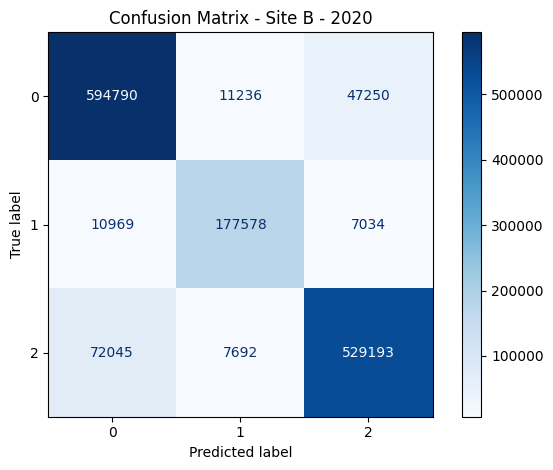


Training with 13900 samples...


Training Epoch 1: 100%|██████████| 218/218 [00:04<00:00, 44.00it/s]


Loss: 0.4036 + 1e-08 * 2859839.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.32it/s]


Epoch [1/15] Train Loss: 0.4664, Train Acc: 0.8392 | Val Loss: 0.3333, Val Acc: 0.8792


Training Epoch 2: 100%|██████████| 218/218 [00:04<00:00, 43.94it/s]


Loss: 0.6477 + 1e-08 * 2837888.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.46it/s]


Epoch [2/15] Train Loss: 0.3103, Train Acc: 0.8892 | Val Loss: 0.3150, Val Acc: 0.8853


Training Epoch 3: 100%|██████████| 218/218 [00:04<00:00, 43.90it/s]


Loss: 0.1031 + 1e-08 * 2817713.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.63it/s]


Epoch [3/15] Train Loss: 0.2867, Train Acc: 0.9027 | Val Loss: 0.3020, Val Acc: 0.8903


Training Epoch 4: 100%|██████████| 218/218 [00:04<00:00, 44.02it/s]


Loss: 0.3203 + 1e-08 * 2798136.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.20it/s]


Epoch [4/15] Train Loss: 0.2664, Train Acc: 0.9064 | Val Loss: 0.3052, Val Acc: 0.8904


Training Epoch 5: 100%|██████████| 218/218 [00:04<00:00, 43.95it/s]


Loss: 0.1329 + 1e-08 * 2779918.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.74it/s]


Epoch [5/15] Train Loss: 0.2534, Train Acc: 0.9130 | Val Loss: 0.2938, Val Acc: 0.8950


Training Epoch 6: 100%|██████████| 218/218 [00:04<00:00, 44.12it/s]


Loss: 0.4382 + 1e-08 * 2764659.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.86it/s]


Epoch [6/15] Train Loss: 0.2371, Train Acc: 0.9196 | Val Loss: 0.2918, Val Acc: 0.8955


Training Epoch 7: 100%|██████████| 218/218 [00:04<00:00, 43.86it/s]


Loss: 0.5544 + 1e-08 * 2754538.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.52it/s]


Epoch [7/15] Train Loss: 0.2331, Train Acc: 0.9207 | Val Loss: 0.2972, Val Acc: 0.8948


Training Epoch 8: 100%|██████████| 218/218 [00:04<00:00, 44.13it/s]


Loss: 0.4891 + 1e-08 * 2747804.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.35it/s]


Epoch [8/15] Train Loss: 0.2217, Train Acc: 0.9229 | Val Loss: 0.3027, Val Acc: 0.8940


Training Epoch 9: 100%|██████████| 218/218 [00:04<00:00, 43.83it/s]


Loss: 0.0850 + 1e-08 * 2742424.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.49it/s]


Epoch [9/15] Train Loss: 0.2107, Train Acc: 0.9283 | Val Loss: 0.2973, Val Acc: 0.8979


Training Epoch 10: 100%|██████████| 218/218 [00:04<00:00, 43.97it/s]


Loss: 0.4313 + 1e-08 * 2739331.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.22it/s]


Epoch [10/15] Train Loss: 0.2024, Train Acc: 0.9325 | Val Loss: 0.3276, Val Acc: 0.8868


Training Epoch 11: 100%|██████████| 218/218 [00:05<00:00, 43.32it/s]


Loss: 0.1007 + 1e-08 * 2739870.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.41it/s]


Epoch [11/15] Train Loss: 0.1899, Train Acc: 0.9363 | Val Loss: 0.3102, Val Acc: 0.8950


Training Epoch 12: 100%|██████████| 218/218 [00:04<00:00, 43.97it/s]


Loss: 0.1424 + 1e-08 * 2743797.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.78it/s]


Epoch [12/15] Train Loss: 0.1783, Train Acc: 0.9376 | Val Loss: 0.3066, Val Acc: 0.8967


Training Epoch 13: 100%|██████████| 218/218 [00:04<00:00, 43.95it/s]


Loss: 0.0121 + 1e-08 * 2750789.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.07it/s]


Epoch [13/15] Train Loss: 0.1758, Train Acc: 0.9432 | Val Loss: 0.3227, Val Acc: 0.8955


Training Epoch 14: 100%|██████████| 218/218 [00:04<00:00, 43.84it/s]


Loss: 0.2850 + 1e-08 * 2755174.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.80it/s]


Epoch [14/15] Train Loss: 0.1604, Train Acc: 0.9504 | Val Loss: 0.3277, Val Acc: 0.8915


Training Epoch 15: 100%|██████████| 218/218 [00:04<00:00, 44.05it/s]


Loss: 0.0760 + 1e-08 * 2764984.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.22it/s]


Epoch [15/15] Train Loss: 0.1520, Train Acc: 0.9538 | Val Loss: 0.3292, Val Acc: 0.8948


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:39<00:00, 142.67it/s]


Stochastic Accuracy (mean over T): 0.8944
Cohen's Kappa: 0.8261
Per-class F1: [0.89473158 0.90581655 0.89023942]
Average F1 (macro): 0.8969


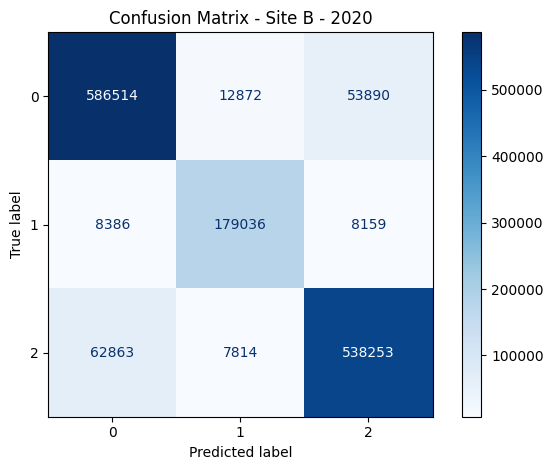


Training with 14200 samples...


Training Epoch 1: 100%|██████████| 222/222 [00:05<00:00, 43.98it/s]


Loss: 0.1979 + 1e-08 * 2859503.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.85it/s]


Epoch [1/15] Train Loss: 0.4656, Train Acc: 0.8392 | Val Loss: 0.3335, Val Acc: 0.8800


Training Epoch 2: 100%|██████████| 222/222 [00:05<00:00, 44.08it/s]


Loss: 0.3127 + 1e-08 * 2836924.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.31it/s]


Epoch [2/15] Train Loss: 0.3095, Train Acc: 0.8893 | Val Loss: 0.3103, Val Acc: 0.8868


Training Epoch 3: 100%|██████████| 222/222 [00:05<00:00, 43.92it/s]


Loss: 0.2445 + 1e-08 * 2813630.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.47it/s]


Epoch [3/15] Train Loss: 0.2854, Train Acc: 0.9004 | Val Loss: 0.3103, Val Acc: 0.8905


Training Epoch 4: 100%|██████████| 222/222 [00:05<00:00, 43.92it/s]


Loss: 0.2050 + 1e-08 * 2791486.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.23it/s]


Epoch [4/15] Train Loss: 0.2689, Train Acc: 0.9048 | Val Loss: 0.2983, Val Acc: 0.8943


Training Epoch 5: 100%|██████████| 222/222 [00:05<00:00, 43.77it/s]


Loss: 0.1007 + 1e-08 * 2770318.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.22it/s]


Epoch [5/15] Train Loss: 0.2557, Train Acc: 0.9111 | Val Loss: 0.2914, Val Acc: 0.8960


Training Epoch 6: 100%|██████████| 222/222 [00:05<00:00, 44.07it/s]


Loss: 0.2180 + 1e-08 * 2753899.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.12it/s]


Epoch [6/15] Train Loss: 0.2411, Train Acc: 0.9173 | Val Loss: 0.2878, Val Acc: 0.8983


Training Epoch 7: 100%|██████████| 222/222 [00:05<00:00, 43.84it/s]


Loss: 0.2597 + 1e-08 * 2742237.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.58it/s]


Epoch [7/15] Train Loss: 0.2317, Train Acc: 0.9204 | Val Loss: 0.2958, Val Acc: 0.8958


Training Epoch 8: 100%|██████████| 222/222 [00:05<00:00, 44.12it/s]


Loss: 0.1491 + 1e-08 * 2734227.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.83it/s]


Epoch [8/15] Train Loss: 0.2230, Train Acc: 0.9246 | Val Loss: 0.2910, Val Acc: 0.8972


Training Epoch 9: 100%|██████████| 222/222 [00:05<00:00, 43.97it/s]


Loss: 0.1448 + 1e-08 * 2730878.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.91it/s]


Epoch [9/15] Train Loss: 0.2151, Train Acc: 0.9272 | Val Loss: 0.2964, Val Acc: 0.8960


Training Epoch 10: 100%|██████████| 222/222 [00:05<00:00, 43.94it/s]


Loss: 0.1811 + 1e-08 * 2726727.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.71it/s]


Epoch [10/15] Train Loss: 0.1997, Train Acc: 0.9331 | Val Loss: 0.3074, Val Acc: 0.8970


Training Epoch 11: 100%|██████████| 222/222 [00:05<00:00, 43.88it/s]


Loss: 0.1567 + 1e-08 * 2727670.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.05it/s]


Epoch [11/15] Train Loss: 0.1932, Train Acc: 0.9338 | Val Loss: 0.3081, Val Acc: 0.8966


Training Epoch 12: 100%|██████████| 222/222 [00:05<00:00, 43.91it/s]


Loss: 0.1084 + 1e-08 * 2731745.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.28it/s]


Epoch [12/15] Train Loss: 0.1820, Train Acc: 0.9404 | Val Loss: 0.3494, Val Acc: 0.8840


Training Epoch 13: 100%|██████████| 222/222 [00:05<00:00, 43.98it/s]


Loss: 0.1443 + 1e-08 * 2738990.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.73it/s]


Epoch [13/15] Train Loss: 0.1732, Train Acc: 0.9440 | Val Loss: 0.3257, Val Acc: 0.8974


Training Epoch 14: 100%|██████████| 222/222 [00:05<00:00, 43.59it/s]


Loss: 0.0969 + 1e-08 * 2746917.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.45it/s]


Epoch [14/15] Train Loss: 0.1605, Train Acc: 0.9485 | Val Loss: 0.3322, Val Acc: 0.8903


Training Epoch 15: 100%|██████████| 222/222 [00:05<00:00, 43.91it/s]


Loss: 0.1510 + 1e-08 * 2753250.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.30it/s]


Epoch [15/15] Train Loss: 0.1485, Train Acc: 0.9527 | Val Loss: 0.3393, Val Acc: 0.8959


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:39<00:00, 142.78it/s]


Stochastic Accuracy (mean over T): 0.8954
Cohen's Kappa: 0.8273
Per-class F1: [0.89362223 0.91190096 0.89204134]
Average F1 (macro): 0.8992


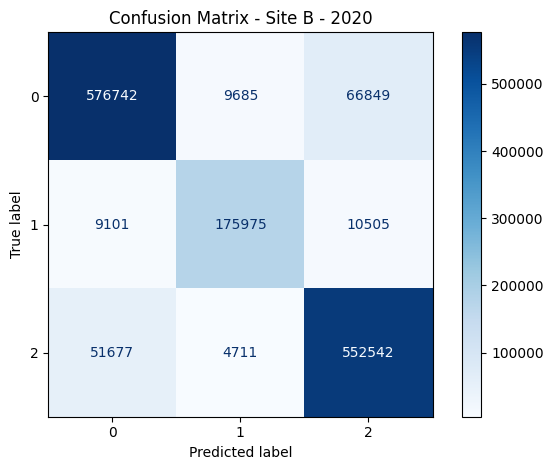


Training with 14500 samples...


Training Epoch 1: 100%|██████████| 227/227 [00:05<00:00, 43.91it/s]


Loss: 0.2929 + 1e-08 * 2858666.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.45it/s]


Epoch [1/15] Train Loss: 0.4667, Train Acc: 0.8400 | Val Loss: 0.3329, Val Acc: 0.8811


Training Epoch 2: 100%|██████████| 227/227 [00:05<00:00, 43.88it/s]


Loss: 0.4122 + 1e-08 * 2837158.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.78it/s]


Epoch [2/15] Train Loss: 0.3105, Train Acc: 0.8901 | Val Loss: 0.3100, Val Acc: 0.8887


Training Epoch 3: 100%|██████████| 227/227 [00:05<00:00, 44.21it/s]


Loss: 0.2083 + 1e-08 * 2815593.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.32it/s]


Epoch [3/15] Train Loss: 0.2850, Train Acc: 0.8998 | Val Loss: 0.3011, Val Acc: 0.8935


Training Epoch 4: 100%|██████████| 227/227 [00:05<00:00, 44.05it/s]


Loss: 0.0612 + 1e-08 * 2795013.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.52it/s]


Epoch [4/15] Train Loss: 0.2674, Train Acc: 0.9046 | Val Loss: 0.2933, Val Acc: 0.8950


Training Epoch 5: 100%|██████████| 227/227 [00:05<00:00, 44.00it/s]


Loss: 0.0984 + 1e-08 * 2775624.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.34it/s]


Epoch [5/15] Train Loss: 0.2563, Train Acc: 0.9119 | Val Loss: 0.2898, Val Acc: 0.8984


Training Epoch 6: 100%|██████████| 227/227 [00:05<00:00, 44.17it/s]


Loss: 0.1897 + 1e-08 * 2758700.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.49it/s]


Epoch [6/15] Train Loss: 0.2412, Train Acc: 0.9162 | Val Loss: 0.2917, Val Acc: 0.8971


Training Epoch 7: 100%|██████████| 227/227 [00:05<00:00, 44.15it/s]


Loss: 0.1729 + 1e-08 * 2746529.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.43it/s]


Epoch [7/15] Train Loss: 0.2303, Train Acc: 0.9236 | Val Loss: 0.2880, Val Acc: 0.8973


Training Epoch 8: 100%|██████████| 227/227 [00:05<00:00, 43.78it/s]


Loss: 0.2292 + 1e-08 * 2737772.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.27it/s]


Epoch [8/15] Train Loss: 0.2222, Train Acc: 0.9253 | Val Loss: 0.3032, Val Acc: 0.8963


Training Epoch 9: 100%|██████████| 227/227 [00:05<00:00, 43.75it/s]


Loss: 0.3471 + 1e-08 * 2734196.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.03it/s]


Epoch [9/15] Train Loss: 0.2124, Train Acc: 0.9274 | Val Loss: 0.3135, Val Acc: 0.8935


Training Epoch 10: 100%|██████████| 227/227 [00:05<00:00, 43.88it/s]


Loss: 0.2033 + 1e-08 * 2734476.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.45it/s]


Epoch [10/15] Train Loss: 0.2015, Train Acc: 0.9334 | Val Loss: 0.3019, Val Acc: 0.8992


Training Epoch 11: 100%|██████████| 227/227 [00:05<00:00, 43.86it/s]


Loss: 0.1277 + 1e-08 * 2734801.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.20it/s]


Epoch [11/15] Train Loss: 0.1913, Train Acc: 0.9357 | Val Loss: 0.3122, Val Acc: 0.8942


Training Epoch 12: 100%|██████████| 227/227 [00:05<00:00, 43.98it/s]


Loss: 0.0809 + 1e-08 * 2741332.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.03it/s]


Epoch [12/15] Train Loss: 0.1851, Train Acc: 0.9367 | Val Loss: 0.3155, Val Acc: 0.8918


Training Epoch 13: 100%|██████████| 227/227 [00:05<00:00, 43.99it/s]


Loss: 0.1852 + 1e-08 * 2745674.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.48it/s]


Epoch [13/15] Train Loss: 0.1698, Train Acc: 0.9457 | Val Loss: 0.3315, Val Acc: 0.8890


Training Epoch 14: 100%|██████████| 227/227 [00:05<00:00, 43.76it/s]


Loss: 0.2527 + 1e-08 * 2754681.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.70it/s]


Epoch [14/15] Train Loss: 0.1652, Train Acc: 0.9472 | Val Loss: 0.3295, Val Acc: 0.8957


Training Epoch 15: 100%|██████████| 227/227 [00:05<00:00, 43.84it/s]


Loss: 0.0950 + 1e-08 * 2764711.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.63it/s]


Epoch [15/15] Train Loss: 0.1549, Train Acc: 0.9512 | Val Loss: 0.3247, Val Acc: 0.8963


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:38<00:00, 143.41it/s]


Stochastic Accuracy (mean over T): 0.8955
Cohen's Kappa: 0.8276
Per-class F1: [0.89532656 0.90803167 0.89159493]
Average F1 (macro): 0.8983


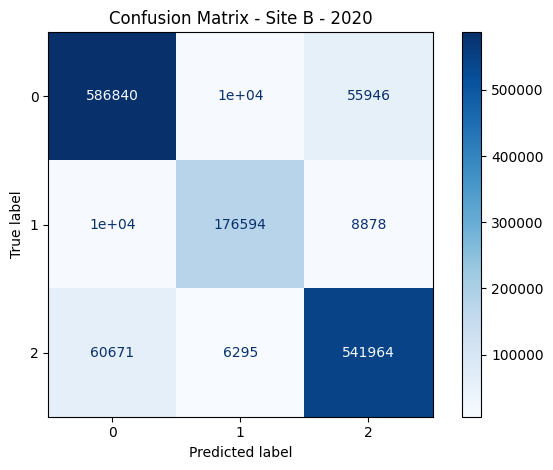


Training with 14800 samples...


Training Epoch 1: 100%|██████████| 232/232 [00:05<00:00, 44.20it/s]


Loss: 0.2441 + 1e-08 * 2860828.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.52it/s]


Epoch [1/15] Train Loss: 0.4609, Train Acc: 0.8380 | Val Loss: 0.3285, Val Acc: 0.8807


Training Epoch 2: 100%|██████████| 232/232 [00:05<00:00, 43.96it/s]


Loss: 0.2206 + 1e-08 * 2838742.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.49it/s]


Epoch [2/15] Train Loss: 0.3067, Train Acc: 0.8937 | Val Loss: 0.3083, Val Acc: 0.8889


Training Epoch 3: 100%|██████████| 232/232 [00:05<00:00, 43.95it/s]


Loss: 0.2739 + 1e-08 * 2814088.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.91it/s]


Epoch [3/15] Train Loss: 0.2827, Train Acc: 0.9016 | Val Loss: 0.3026, Val Acc: 0.8917


Training Epoch 4: 100%|██████████| 232/232 [00:05<00:00, 43.97it/s]


Loss: 0.8015 + 1e-08 * 2794302.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.82it/s]


Epoch [4/15] Train Loss: 0.2683, Train Acc: 0.9056 | Val Loss: 0.2997, Val Acc: 0.8954


Training Epoch 5: 100%|██████████| 232/232 [00:05<00:00, 43.91it/s]


Loss: 0.6451 + 1e-08 * 2773930.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.24it/s]


Epoch [5/15] Train Loss: 0.2541, Train Acc: 0.9108 | Val Loss: 0.2882, Val Acc: 0.8972


Training Epoch 6: 100%|██████████| 232/232 [00:05<00:00, 43.97it/s]


Loss: 0.2019 + 1e-08 * 2759474.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.29it/s]


Epoch [6/15] Train Loss: 0.2439, Train Acc: 0.9155 | Val Loss: 0.2870, Val Acc: 0.8982


Training Epoch 7: 100%|██████████| 232/232 [00:05<00:00, 44.02it/s]


Loss: 0.1498 + 1e-08 * 2746808.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.81it/s]


Epoch [7/15] Train Loss: 0.2349, Train Acc: 0.9201 | Val Loss: 0.2977, Val Acc: 0.8925


Training Epoch 8: 100%|██████████| 232/232 [00:05<00:00, 43.97it/s]


Loss: 0.1402 + 1e-08 * 2737665.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.67it/s]


Epoch [8/15] Train Loss: 0.2215, Train Acc: 0.9245 | Val Loss: 0.3002, Val Acc: 0.8934


Training Epoch 9: 100%|██████████| 232/232 [00:05<00:00, 43.92it/s]


Loss: 0.1067 + 1e-08 * 2730811.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.55it/s]


Epoch [9/15] Train Loss: 0.2104, Train Acc: 0.9282 | Val Loss: 0.2951, Val Acc: 0.8967


Training Epoch 10: 100%|██████████| 232/232 [00:05<00:00, 43.98it/s]


Loss: 0.3032 + 1e-08 * 2729352.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.54it/s]


Epoch [10/15] Train Loss: 0.2003, Train Acc: 0.9322 | Val Loss: 0.2967, Val Acc: 0.8966


Training Epoch 11: 100%|██████████| 232/232 [00:05<00:00, 43.91it/s]


Loss: 0.1826 + 1e-08 * 2731321.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.07it/s]


Epoch [11/15] Train Loss: 0.1939, Train Acc: 0.9357 | Val Loss: 0.3045, Val Acc: 0.8976


Training Epoch 12: 100%|██████████| 232/232 [00:05<00:00, 44.05it/s]


Loss: 0.0179 + 1e-08 * 2735236.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.24it/s]


Epoch [12/15] Train Loss: 0.1821, Train Acc: 0.9374 | Val Loss: 0.3078, Val Acc: 0.8967


Training Epoch 13: 100%|██████████| 232/232 [00:05<00:00, 44.11it/s]


Loss: 0.2132 + 1e-08 * 2738518.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.58it/s]


Epoch [13/15] Train Loss: 0.1710, Train Acc: 0.9440 | Val Loss: 0.3194, Val Acc: 0.8948


Training Epoch 14: 100%|██████████| 232/232 [00:05<00:00, 44.07it/s]


Loss: 0.0587 + 1e-08 * 2747235.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.02it/s]


Epoch [14/15] Train Loss: 0.1632, Train Acc: 0.9478 | Val Loss: 0.3199, Val Acc: 0.8973


Training Epoch 15: 100%|██████████| 232/232 [00:05<00:00, 44.13it/s]


Loss: 0.0674 + 1e-08 * 2756063.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.30it/s]


Epoch [15/15] Train Loss: 0.1504, Train Acc: 0.9522 | Val Loss: 0.3383, Val Acc: 0.8952


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:39<00:00, 143.16it/s]


Stochastic Accuracy (mean over T): 0.8951
Cohen's Kappa: 0.8267
Per-class F1: [0.89392248 0.91165105 0.89115416]
Average F1 (macro): 0.8989


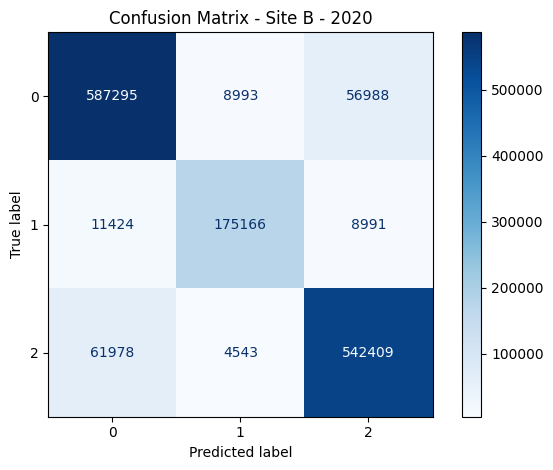


Training with 15100 samples...


Training Epoch 1: 100%|██████████| 236/236 [00:05<00:00, 44.13it/s]


Loss: 0.3347 + 1e-08 * 2859568.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.09it/s]


Epoch [1/15] Train Loss: 0.4577, Train Acc: 0.8418 | Val Loss: 0.3303, Val Acc: 0.8783


Training Epoch 2: 100%|██████████| 236/236 [00:05<00:00, 44.06it/s]


Loss: 0.4159 + 1e-08 * 2835845.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.05it/s]


Epoch [2/15] Train Loss: 0.3053, Train Acc: 0.8917 | Val Loss: 0.3149, Val Acc: 0.8848


Training Epoch 3: 100%|██████████| 236/236 [00:05<00:00, 43.93it/s]


Loss: 0.2544 + 1e-08 * 2811434.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.95it/s]


Epoch [3/15] Train Loss: 0.2808, Train Acc: 0.9023 | Val Loss: 0.2986, Val Acc: 0.8938


Training Epoch 4: 100%|██████████| 236/236 [00:05<00:00, 43.95it/s]


Loss: 0.2189 + 1e-08 * 2789508.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.04it/s]


Epoch [4/15] Train Loss: 0.2670, Train Acc: 0.9079 | Val Loss: 0.2900, Val Acc: 0.8970


Training Epoch 5: 100%|██████████| 236/236 [00:05<00:00, 44.22it/s]


Loss: 0.1842 + 1e-08 * 2769765.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.05it/s]


Epoch [5/15] Train Loss: 0.2523, Train Acc: 0.9130 | Val Loss: 0.2881, Val Acc: 0.9000


Training Epoch 6: 100%|██████████| 236/236 [00:05<00:00, 43.97it/s]


Loss: 0.2375 + 1e-08 * 2755121.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.42it/s]


Epoch [6/15] Train Loss: 0.2423, Train Acc: 0.9182 | Val Loss: 0.2921, Val Acc: 0.8959


Training Epoch 7: 100%|██████████| 236/236 [00:05<00:00, 43.99it/s]


Loss: 0.1827 + 1e-08 * 2742833.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.34it/s]


Epoch [7/15] Train Loss: 0.2293, Train Acc: 0.9217 | Val Loss: 0.2958, Val Acc: 0.8963


Training Epoch 8: 100%|██████████| 236/236 [00:05<00:00, 43.99it/s]


Loss: 0.1959 + 1e-08 * 2733348.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.76it/s]


Epoch [8/15] Train Loss: 0.2222, Train Acc: 0.9260 | Val Loss: 0.2909, Val Acc: 0.8989


Training Epoch 9: 100%|██████████| 236/236 [00:05<00:00, 43.76it/s]


Loss: 0.1119 + 1e-08 * 2729608.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.27it/s]


Epoch [9/15] Train Loss: 0.2122, Train Acc: 0.9277 | Val Loss: 0.3043, Val Acc: 0.8954


Training Epoch 10: 100%|██████████| 236/236 [00:05<00:00, 44.03it/s]


Loss: 0.1517 + 1e-08 * 2730921.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.38it/s]


Epoch [10/15] Train Loss: 0.2019, Train Acc: 0.9334 | Val Loss: 0.3210, Val Acc: 0.8937


Training Epoch 11: 100%|██████████| 236/236 [00:05<00:00, 43.91it/s]


Loss: 0.1860 + 1e-08 * 2731748.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.42it/s]


Epoch [11/15] Train Loss: 0.1906, Train Acc: 0.9352 | Val Loss: 0.3033, Val Acc: 0.8969


Training Epoch 12: 100%|██████████| 236/236 [00:05<00:00, 43.75it/s]


Loss: 0.1996 + 1e-08 * 2737442.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.47it/s]


Epoch [12/15] Train Loss: 0.1818, Train Acc: 0.9395 | Val Loss: 0.3136, Val Acc: 0.8957


Training Epoch 13: 100%|██████████| 236/236 [00:05<00:00, 43.99it/s]


Loss: 0.1528 + 1e-08 * 2742163.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.77it/s]


Epoch [13/15] Train Loss: 0.1704, Train Acc: 0.9434 | Val Loss: 0.3327, Val Acc: 0.8884


Training Epoch 14: 100%|██████████| 236/236 [00:05<00:00, 44.07it/s]


Loss: 0.0606 + 1e-08 * 2750085.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.96it/s]


Epoch [14/15] Train Loss: 0.1582, Train Acc: 0.9503 | Val Loss: 0.3372, Val Acc: 0.8893


Training Epoch 15: 100%|██████████| 236/236 [00:05<00:00, 43.84it/s]


Loss: 0.1101 + 1e-08 * 2759678.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.85it/s]


Epoch [15/15] Train Loss: 0.1494, Train Acc: 0.9521 | Val Loss: 0.3403, Val Acc: 0.8919


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:39<00:00, 142.54it/s]


Stochastic Accuracy (mean over T): 0.8920
Cohen's Kappa: 0.8224
Per-class F1: [0.89132878 0.90191247 0.88951694]
Average F1 (macro): 0.8943


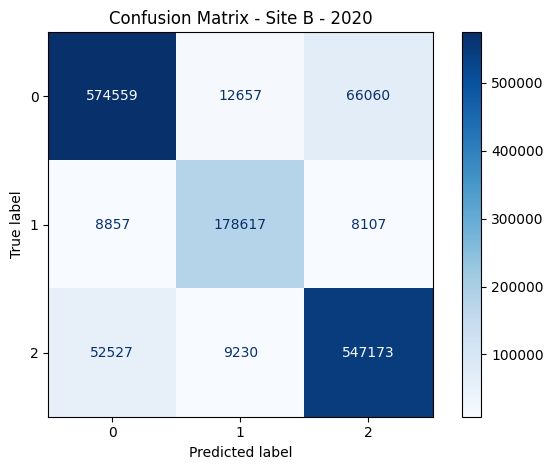


Training with 15400 samples...


Training Epoch 1: 100%|██████████| 241/241 [00:05<00:00, 43.95it/s]


Loss: 0.4137 + 1e-08 * 2858073.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.18it/s]


Epoch [1/15] Train Loss: 0.4583, Train Acc: 0.8421 | Val Loss: 0.3559, Val Acc: 0.8671


Training Epoch 2: 100%|██████████| 241/241 [00:05<00:00, 44.32it/s]


Loss: 0.2760 + 1e-08 * 2832974.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.64it/s]


Epoch [2/15] Train Loss: 0.3065, Train Acc: 0.8911 | Val Loss: 0.3152, Val Acc: 0.8846


Training Epoch 3: 100%|██████████| 241/241 [00:05<00:00, 43.89it/s]


Loss: 0.3120 + 1e-08 * 2806976.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.63it/s]


Epoch [3/15] Train Loss: 0.2827, Train Acc: 0.9016 | Val Loss: 0.3046, Val Acc: 0.8919


Training Epoch 4: 100%|██████████| 241/241 [00:05<00:00, 43.96it/s]


Loss: 0.2528 + 1e-08 * 2782245.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.44it/s]


Epoch [4/15] Train Loss: 0.2666, Train Acc: 0.9055 | Val Loss: 0.2886, Val Acc: 0.8982


Training Epoch 5: 100%|██████████| 241/241 [00:05<00:00, 43.85it/s]


Loss: 0.3556 + 1e-08 * 2761336.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.56it/s]


Epoch [5/15] Train Loss: 0.2551, Train Acc: 0.9117 | Val Loss: 0.2882, Val Acc: 0.8984


Training Epoch 6: 100%|██████████| 241/241 [00:05<00:00, 43.59it/s]


Loss: 0.2154 + 1e-08 * 2744308.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.96it/s]


Epoch [6/15] Train Loss: 0.2446, Train Acc: 0.9161 | Val Loss: 0.2883, Val Acc: 0.8976


Training Epoch 7: 100%|██████████| 241/241 [00:05<00:00, 43.94it/s]


Loss: 0.1378 + 1e-08 * 2730604.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.50it/s]


Epoch [7/15] Train Loss: 0.2337, Train Acc: 0.9204 | Val Loss: 0.2896, Val Acc: 0.8985


Training Epoch 8: 100%|██████████| 241/241 [00:05<00:00, 43.87it/s]


Loss: 0.2571 + 1e-08 * 2721455.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.89it/s]


Epoch [8/15] Train Loss: 0.2230, Train Acc: 0.9234 | Val Loss: 0.2913, Val Acc: 0.8971


Training Epoch 9: 100%|██████████| 241/241 [00:05<00:00, 43.90it/s]


Loss: 0.1167 + 1e-08 * 2716797.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.55it/s]


Epoch [9/15] Train Loss: 0.2148, Train Acc: 0.9266 | Val Loss: 0.3000, Val Acc: 0.8967


Training Epoch 10: 100%|██████████| 241/241 [00:05<00:00, 44.02it/s]


Loss: 0.0506 + 1e-08 * 2714184.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.18it/s]


Epoch [10/15] Train Loss: 0.1998, Train Acc: 0.9326 | Val Loss: 0.2953, Val Acc: 0.9000


Training Epoch 11: 100%|██████████| 241/241 [00:05<00:00, 43.94it/s]


Loss: 0.0895 + 1e-08 * 2716335.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.23it/s]


Epoch [11/15] Train Loss: 0.1957, Train Acc: 0.9355 | Val Loss: 0.3161, Val Acc: 0.8950


Training Epoch 12: 100%|██████████| 241/241 [00:05<00:00, 44.00it/s]


Loss: 0.1315 + 1e-08 * 2717950.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.84it/s]


Epoch [12/15] Train Loss: 0.1827, Train Acc: 0.9408 | Val Loss: 0.3246, Val Acc: 0.8926


Training Epoch 13: 100%|██████████| 241/241 [00:05<00:00, 43.98it/s]


Loss: 0.1286 + 1e-08 * 2721574.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.99it/s]


Epoch [13/15] Train Loss: 0.1756, Train Acc: 0.9411 | Val Loss: 0.3262, Val Acc: 0.8966


Training Epoch 14: 100%|██████████| 241/241 [00:05<00:00, 44.00it/s]


Loss: 0.1884 + 1e-08 * 2728667.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.10it/s]


Epoch [14/15] Train Loss: 0.1646, Train Acc: 0.9460 | Val Loss: 0.3215, Val Acc: 0.8948


Training Epoch 15: 100%|██████████| 241/241 [00:05<00:00, 43.96it/s]


Loss: 0.0601 + 1e-08 * 2735802.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.61it/s]


Epoch [15/15] Train Loss: 0.1559, Train Acc: 0.9503 | Val Loss: 0.3504, Val Acc: 0.8859


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:39<00:00, 142.53it/s]


Stochastic Accuracy (mean over T): 0.8858
Cohen's Kappa: 0.8127
Per-class F1: [0.88102016 0.89960697 0.88617027]
Average F1 (macro): 0.8889


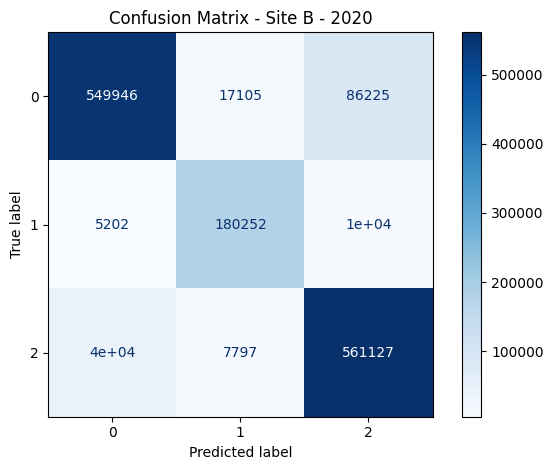


Training with 15700 samples...


Training Epoch 1: 100%|██████████| 246/246 [00:05<00:00, 43.70it/s]


Loss: 0.2280 + 1e-08 * 2858355.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.79it/s]


Epoch [1/15] Train Loss: 0.4555, Train Acc: 0.8403 | Val Loss: 0.3279, Val Acc: 0.8798


Training Epoch 2: 100%|██████████| 246/246 [00:05<00:00, 43.74it/s]


Loss: 0.3099 + 1e-08 * 2836467.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.68it/s]


Epoch [2/15] Train Loss: 0.3114, Train Acc: 0.8898 | Val Loss: 0.3121, Val Acc: 0.8867


Training Epoch 3: 100%|██████████| 246/246 [00:05<00:00, 43.82it/s]


Loss: 0.1562 + 1e-08 * 2807490.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.31it/s]


Epoch [3/15] Train Loss: 0.2790, Train Acc: 0.9015 | Val Loss: 0.3003, Val Acc: 0.8942


Training Epoch 4: 100%|██████████| 246/246 [00:05<00:00, 43.76it/s]


Loss: 0.7751 + 1e-08 * 2782037.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.60it/s]


Epoch [4/15] Train Loss: 0.2642, Train Acc: 0.9083 | Val Loss: 0.2990, Val Acc: 0.8912


Training Epoch 5: 100%|██████████| 246/246 [00:05<00:00, 44.14it/s]


Loss: 0.2217 + 1e-08 * 2761539.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.79it/s]


Epoch [5/15] Train Loss: 0.2573, Train Acc: 0.9117 | Val Loss: 0.2863, Val Acc: 0.8980


Training Epoch 6: 100%|██████████| 246/246 [00:05<00:00, 43.78it/s]


Loss: 0.1054 + 1e-08 * 2742426.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.52it/s]


Epoch [6/15] Train Loss: 0.2415, Train Acc: 0.9192 | Val Loss: 0.2915, Val Acc: 0.8987


Training Epoch 7: 100%|██████████| 246/246 [00:05<00:00, 43.99it/s]


Loss: 0.2071 + 1e-08 * 2729396.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.04it/s]


Epoch [7/15] Train Loss: 0.2326, Train Acc: 0.9189 | Val Loss: 0.2856, Val Acc: 0.8988


Training Epoch 8: 100%|██████████| 246/246 [00:05<00:00, 43.87it/s]


Loss: 0.0683 + 1e-08 * 2720616.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.47it/s]


Epoch [8/15] Train Loss: 0.2227, Train Acc: 0.9243 | Val Loss: 0.2894, Val Acc: 0.8993


Training Epoch 9: 100%|██████████| 246/246 [00:05<00:00, 43.96it/s]


Loss: 0.3082 + 1e-08 * 2715176.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.63it/s]


Epoch [9/15] Train Loss: 0.2134, Train Acc: 0.9282 | Val Loss: 0.3032, Val Acc: 0.8937


Training Epoch 10: 100%|██████████| 246/246 [00:05<00:00, 43.96it/s]


Loss: 0.1788 + 1e-08 * 2712784.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.46it/s]


Epoch [10/15] Train Loss: 0.1998, Train Acc: 0.9354 | Val Loss: 0.2966, Val Acc: 0.8980


Training Epoch 11: 100%|██████████| 246/246 [00:05<00:00, 43.85it/s]


Loss: 0.3669 + 1e-08 * 2713704.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.50it/s]


Epoch [11/15] Train Loss: 0.1891, Train Acc: 0.9377 | Val Loss: 0.3079, Val Acc: 0.8973


Training Epoch 12: 100%|██████████| 246/246 [00:05<00:00, 43.91it/s]


Loss: 0.3296 + 1e-08 * 2717254.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.13it/s]


Epoch [12/15] Train Loss: 0.1797, Train Acc: 0.9409 | Val Loss: 0.3134, Val Acc: 0.8981


Training Epoch 13: 100%|██████████| 246/246 [00:05<00:00, 43.86it/s]


Loss: 0.0710 + 1e-08 * 2725375.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.59it/s]


Epoch [13/15] Train Loss: 0.1714, Train Acc: 0.9432 | Val Loss: 0.3212, Val Acc: 0.8939


Training Epoch 14: 100%|██████████| 246/246 [00:05<00:00, 43.95it/s]


Loss: 0.0400 + 1e-08 * 2733420.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.40it/s]


Epoch [14/15] Train Loss: 0.1612, Train Acc: 0.9481 | Val Loss: 0.3426, Val Acc: 0.8914


Training Epoch 15: 100%|██████████| 246/246 [00:05<00:00, 43.98it/s]


Loss: 0.1008 + 1e-08 * 2739659.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.45it/s]


Epoch [15/15] Train Loss: 0.1495, Train Acc: 0.9519 | Val Loss: 0.3281, Val Acc: 0.8953


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:38<00:00, 143.34it/s]


Stochastic Accuracy (mean over T): 0.8956
Cohen's Kappa: 0.8279
Per-class F1: [0.89615378 0.90781202 0.89101313]
Average F1 (macro): 0.8983


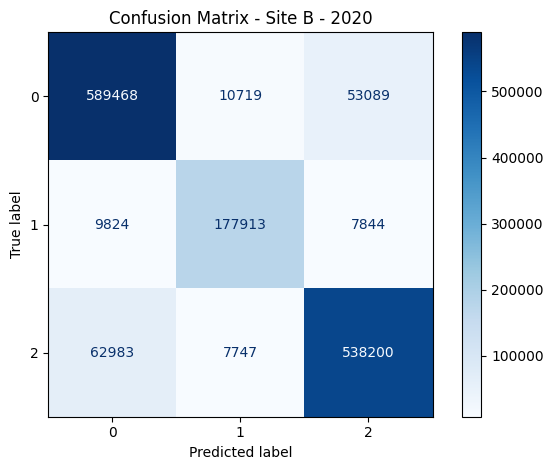


Training with 16000 samples...


Training Epoch 1: 100%|██████████| 250/250 [00:05<00:00, 43.81it/s]


Loss: 0.3448 + 1e-08 * 2856214.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.30it/s]


Epoch [1/15] Train Loss: 0.4440, Train Acc: 0.8430 | Val Loss: 0.3339, Val Acc: 0.8807


Training Epoch 2: 100%|██████████| 250/250 [00:05<00:00, 43.79it/s]


Loss: 0.3733 + 1e-08 * 2831327.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.68it/s]


Epoch [2/15] Train Loss: 0.3057, Train Acc: 0.8892 | Val Loss: 0.3048, Val Acc: 0.8894


Training Epoch 3: 100%|██████████| 250/250 [00:05<00:00, 43.98it/s]


Loss: 0.1885 + 1e-08 * 2807512.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.45it/s]


Epoch [3/15] Train Loss: 0.2809, Train Acc: 0.9012 | Val Loss: 0.3028, Val Acc: 0.8925


Training Epoch 4: 100%|██████████| 250/250 [00:05<00:00, 43.87it/s]


Loss: 0.4516 + 1e-08 * 2781299.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.93it/s]


Epoch [4/15] Train Loss: 0.2658, Train Acc: 0.9098 | Val Loss: 0.2961, Val Acc: 0.8945


Training Epoch 5: 100%|██████████| 250/250 [00:05<00:00, 43.98it/s]


Loss: 0.2377 + 1e-08 * 2758514.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.90it/s]


Epoch [5/15] Train Loss: 0.2548, Train Acc: 0.9129 | Val Loss: 0.2864, Val Acc: 0.8988


Training Epoch 6: 100%|██████████| 250/250 [00:05<00:00, 43.92it/s]


Loss: 0.2870 + 1e-08 * 2741190.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.38it/s]


Epoch [6/15] Train Loss: 0.2405, Train Acc: 0.9163 | Val Loss: 0.2914, Val Acc: 0.8949


Training Epoch 7: 100%|██████████| 250/250 [00:05<00:00, 43.95it/s]


Loss: 0.1996 + 1e-08 * 2724468.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.93it/s]


Epoch [7/15] Train Loss: 0.2341, Train Acc: 0.9207 | Val Loss: 0.2885, Val Acc: 0.8991


Training Epoch 8: 100%|██████████| 250/250 [00:05<00:00, 44.05it/s]


Loss: 0.2645 + 1e-08 * 2714869.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.85it/s]


Epoch [8/15] Train Loss: 0.2215, Train Acc: 0.9233 | Val Loss: 0.2906, Val Acc: 0.9001


Training Epoch 9: 100%|██████████| 250/250 [00:05<00:00, 43.74it/s]


Loss: 0.4614 + 1e-08 * 2709778.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.16it/s]


Epoch [9/15] Train Loss: 0.2147, Train Acc: 0.9270 | Val Loss: 0.3025, Val Acc: 0.8948


Training Epoch 10: 100%|██████████| 250/250 [00:05<00:00, 43.98it/s]


Loss: 0.1416 + 1e-08 * 2705808.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.58it/s]


Epoch [10/15] Train Loss: 0.2021, Train Acc: 0.9319 | Val Loss: 0.3063, Val Acc: 0.8953


Training Epoch 11: 100%|██████████| 250/250 [00:05<00:00, 43.83it/s]


Loss: 0.1893 + 1e-08 * 2708952.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.34it/s]


Epoch [11/15] Train Loss: 0.1932, Train Acc: 0.9362 | Val Loss: 0.3029, Val Acc: 0.8981


Training Epoch 12: 100%|██████████| 250/250 [00:05<00:00, 44.03it/s]


Loss: 0.0982 + 1e-08 * 2711015.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.49it/s]


Epoch [12/15] Train Loss: 0.1840, Train Acc: 0.9381 | Val Loss: 0.3109, Val Acc: 0.8947


Training Epoch 13: 100%|██████████| 250/250 [00:05<00:00, 43.91it/s]


Loss: 0.1090 + 1e-08 * 2718910.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.00it/s]


Epoch [13/15] Train Loss: 0.1745, Train Acc: 0.9433 | Val Loss: 0.3143, Val Acc: 0.8975


Training Epoch 14: 100%|██████████| 250/250 [00:05<00:00, 43.99it/s]


Loss: 0.0904 + 1e-08 * 2724132.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.09it/s]


Epoch [14/15] Train Loss: 0.1641, Train Acc: 0.9469 | Val Loss: 0.3223, Val Acc: 0.8974


Training Epoch 15: 100%|██████████| 250/250 [00:05<00:00, 44.05it/s]


Loss: 0.1795 + 1e-08 * 2731481.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.55it/s]


Epoch [15/15] Train Loss: 0.1542, Train Acc: 0.9509 | Val Loss: 0.3299, Val Acc: 0.8945


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:40<00:00, 141.54it/s]


Stochastic Accuracy (mean over T): 0.8944
Cohen's Kappa: 0.8262
Per-class F1: [0.89492882 0.90670403 0.88994861]
Average F1 (macro): 0.8972


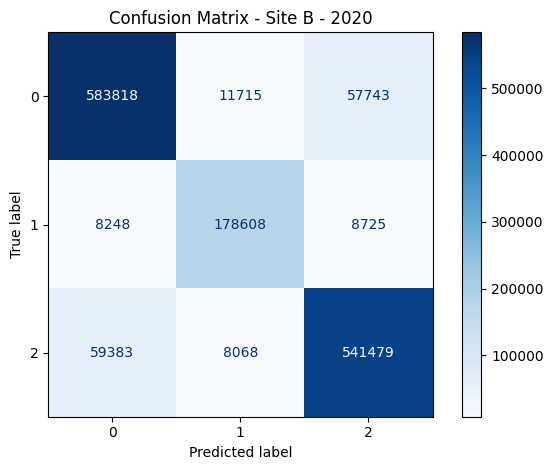

In [29]:
# Subsampled Training
if flag_subsampled:
    elbow_history = subsampled_training(X_train, y_train, val_dataloader, start=13000, end=16000, step=300)
    
else: 
    # Simple training
    train_losses, val_losses, train_accs, val_accs = train(model, train_dataset, train_dataloader, val_dataloader, optimizer, KL_WEIGHT=KL_WEIGHT, EPOCHS=EPOCHS, T=T)

    acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, T, device=DEVICE)
    
    # Printing and plotting
    print("Stochastic" + f" Accuracy (mean over T): {acc:.4f}" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Per-class F1: {per_class_f1}")
    print(f"Average F1 (macro): {avg_f1:.4f}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
    plt.tight_layout()
    plt.show()

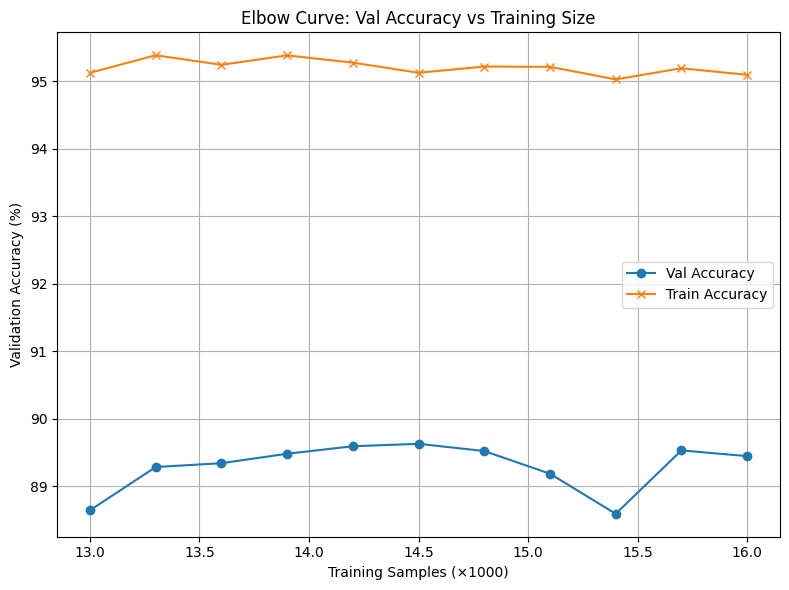

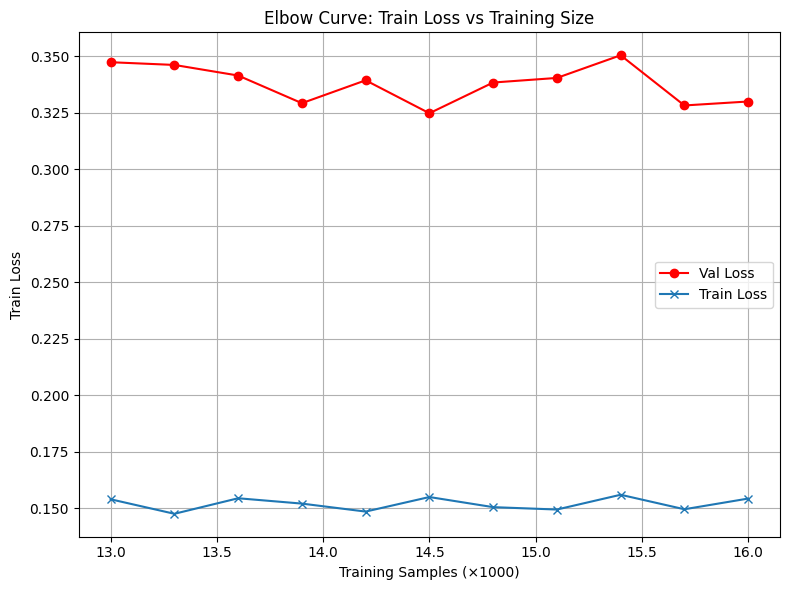

In [30]:
if flag_subsampled:
    def plot_elbow_curve(elbow_history):
        x_vals = [x / 1000 for x in elbow_history["subset_size"]]
    
        # Accuracy
        plt.figure(figsize=(8, 6))
        y_vals = [acc * 100 for acc in elbow_history["val_accuracy"]]
        plt.plot(x_vals, y_vals, marker='o', label='Val Accuracy')
        plt.plot(x_vals, [acc * 100 for acc in elbow_history['train_accuracy']], marker='x', label='Train Accuracy')
        plt.xlabel("Training Samples (×1000)")
        plt.ylabel("Validation Accuracy (%)")
        plt.title("Elbow Curve: Val Accuracy vs Training Size")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
        # Train Loss
        plt.figure(figsize=(8, 6))
        y_vals = elbow_history["val_loss"]  # raw loss
        plt.plot(x_vals, y_vals, marker='o', color='red', label='Val Loss')
        plt.plot(x_vals, elbow_history["train_loss"], marker='x', label='Train Loss')
        plt.xlabel("Training Samples (×1000)")
        plt.ylabel("Train Loss")
        plt.title("Elbow Curve: Train Loss vs Training Size")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    plot_elbow_curve(elbow_history)

else: 
    epochs = range(1, EPOCHS + 1)

    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Val Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Val Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## Saving Results

In [31]:
if flag_subsampled:
    def save_elbow_results_to_excel(filename, elbow_history):
        # Load or create workbook
        if os.path.exists(filename):
            wb = load_workbook(filename)
            ws = wb.active
        else:
            wb = Workbook()
            ws = wb.active
    
            # Header row with bold font
            headers = ["Experiments", "Results"]
            bold_font = Font(bold=True)
            ws.append(headers)
    
            for col_num in range(1, len(headers) + 1):
                ws.cell(row=1, column=col_num).font = bold_font
    
        # For each subset size, append a row
        for i in range(len(elbow_history["subset_size"])):
            subset = elbow_history["subset_size"][i]
            train_acc = elbow_history["train_accuracy"][i] * 100
            train_loss = elbow_history["train_loss"][i]
            val_acc = elbow_history["val_accuracy"][i] * 100
            val_loss = elbow_history["val_loss"][i]
            val_avg_f1 = elbow_history["val_avg_f1"][i] * 100
            kappa = elbow_history["kappa"][i]
    
    
            experiment_name = f"Labeled Samples: {subset}"
            results_str = (
                f"TrainAcc = {train_acc:.2f}%, "
                f"TrainLoss = {train_loss:.4f},\n"
                f"ValAcc = {val_acc:.2f}%, "
                f"ValLoss = {val_loss:.4f},\n"
                f"AvgF1 = {val_avg_f1:.2f}%, "
                f"Kappa = {kappa:.4f}"
            )
    
            ws.append([experiment_name, results_str])
    
        wb.save(filename)
        print(f"Results saved to {filename}")
    
save_elbow_results_to_excel(
    filename="Results.xlsx",
    elbow_history=elbow_history
)

Results saved to Results.xlsx


<hr>